<a href="https://colab.research.google.com/github/tzs930/deeprl_practice_colab/blob/master/day3/day3_GAIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAIL (Generative Adversarial Imitation Learning) 실습

이번 실습자료는 GAIL 저자 (Jonathan Ho)의  [구현코드](/https://github.com/openai/imitation.git)를 바탕으로 제작되었습니다. 직접적인 구현 자체 (`TrainsitionClassifier`, `ImitationOptimizer`) 위주로 실습자료를 만들었고, 구현에 필요한 유틸리티 메서드들은 저자코드 저장소에서 그대로 받아와서 사용하게 됩니다. 

## 환경설정

In [0]:
!pip install theano==0.8.2 gym==0.1.0 mujoco_py==0.4.0

In [24]:
!git init .
!git remote add origin https://github.com/tzs930/imitation.git
!git pull origin master

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/tzs930/imitation
 * branch            master     -> FETCH_HEAD
   e338184..0be23b1  master     -> origin/master
Updating e338184..0be23b1
Fast-forward
 policyopt/nn.py | 3 ++-
 1 file changed, 2 insertions(+), 1 deletion(-)


## Generative Adversarial Learning을 통해 Reward를 학습 : `class TrainsitionClassifier`

In [0]:
from policyopt import nn, rl, util, RaggedArray, ContinuousSpace, FiniteSpace, optim, thutil
import numpy as np
from contextlib import contextmanager
import theano; from theano import tensor

class TransitionClassifier(nn.Model):
    '''Reward/adversary for generative-adversarial training'''

    def __init__(self, obsfeat_space, action_space, hidden_spec, max_kl, adam_lr, adam_steps, ent_reg_weight,
                 enable_inputnorm, include_time, time_scale, favor_zero_expert_reward, varscope_name):
        self.obsfeat_space, self.action_space = obsfeat_space, action_space
        self.hidden_spec = hidden_spec
        self.max_kl = max_kl
        self.adam_steps = adam_steps
        self.ent_reg_weight = ent_reg_weight; assert ent_reg_weight >= 0
        self.include_time = include_time
        self.time_scale = time_scale
        self.favor_zero_expert_reward = favor_zero_expert_reward

        with nn.variable_scope(varscope_name) as self.__varscope:
            # Map (s,a) pairs to classifier scores (log probabilities of classes)
            obsfeat_B_Df = tensor.matrix(name='obsfeat_B_Df')
            a_B_Da = tensor.matrix(name='a_B_Da', dtype=theano.config.floatX if self.action_space.storage_type == float else 'int64')
            t_B = tensor.vector(name='t_B')

            scaled_t_B = self.time_scale * t_B

            if isinstance(self.action_space, ContinuousSpace):
                # For a continuous action space, map observation-action pairs to a real number (reward)
                trans_B_Doa = tensor.concatenate([obsfeat_B_Df, a_B_Da], axis=1)
                trans_dim = self.obsfeat_space.dim + self.action_space.dim
                # Normalize
                with nn.variable_scope('inputnorm'):
                    self.inputnorm = (nn.Standardizer if enable_inputnorm else nn.NoOpStandardizer)(self.obsfeat_space.dim + self.action_space.dim)
                normedtrans_B_Doa = self.inputnorm.standardize_expr(trans_B_Doa)
                if self.include_time:
                    net_input = tensor.concatenate([normedtrans_B_Doa, scaled_t_B[:,None]], axis=1)
                    net_input_dim = trans_dim + 1
                else:
                    net_input = normedtrans_B_Doa
                    net_input_dim = trans_dim
                # Compute scores
                with nn.variable_scope('hidden'):
                    net = nn.FeedforwardNet(net_input, (net_input_dim,), self.hidden_spec)
                with nn.variable_scope('out'):
                    out_layer = nn.AffineLayer(net.output, net.output_shape, (1,), initializer=np.zeros((net.output_shape[0], 1)))
                scores_B = out_layer.output[:,0]

            else:
                # For a finite action space, map observation observations to a vector of rewards

                # Normalize observations
                with nn.variable_scope('inputnorm'):
                    self.inputnorm = (nn.Standardizer if enable_inputnorm else nn.NoOpStandardizer)(self.obsfeat_space.dim)
                normedobs_B_Df = self.inputnorm.standardize_expr(obsfeat_B_Df)
                if self.include_time:
                    net_input = tensor.concatenate([normedobs_B_Df, scaled_t_B[:,None]], axis=1)
                    net_input_dim = self.obsfeat_space.dim + 1
                else:
                    net_input = normedobs_B_Df
                    net_input_dim = self.obsfeat_space.dim
                # Compute scores
                with nn.variable_scope('hidden'):
                    net = nn.FeedforwardNet(net_input, (net_input_dim,), self.hidden_spec)
                with nn.variable_scope('out'):
                    out_layer = nn.AffineLayer(
                        net.output, net.output_shape, (self.action_space.size,),
                        initializer=np.zeros((net.output_shape[0], self.action_space.size)))
                scores_B = out_layer.output[tensor.arange(normedobs_B_Df.shape[0]), a_B_Da[:,0]]


        if self.include_time:
            self._compute_scores = thutil.function([obsfeat_B_Df, a_B_Da, t_B], scores_B) # scores define the conditional distribution p(label | (state,action))
        else:
            compute_scores_without_time = thutil.function([obsfeat_B_Df, a_B_Da], scores_B)
            self._compute_scores = lambda _obsfeat_B_Df, _a_B_Da, _t_B: compute_scores_without_time(_obsfeat_B_Df, _a_B_Da)

        if self.favor_zero_expert_reward:
            # 0 for expert-like states, goes to -inf for non-expert-like states
            # compatible with envs with traj cutoffs for good (expert-like) behavior
            # e.g. mountain car, which gets cut off when the car reaches the destination
            rewards_B = thutil.logsigmoid(scores_B)
        else:
            # 0 for non-expert-like states, goes to +inf for expert-like states
            # compatible with envs with traj cutoffs for bad (non-expert-like) behavior
            # e.g. walking simulations that get cut off when the robot falls over
            rewards_B = -tensor.log(1.-tensor.nnet.sigmoid(scores_B))
        if self.include_time:
            self._compute_reward = thutil.function([obsfeat_B_Df, a_B_Da, t_B], rewards_B)
        else:
            compute_reward_without_time = thutil.function([obsfeat_B_Df, a_B_Da], rewards_B)
            self._compute_reward = lambda _obsfeat_B_Df, _a_B_Da, _t_B: compute_reward_without_time(_obsfeat_B_Df, _a_B_Da)

        param_vars = self.get_trainable_variables()

        # Logistic regression loss, regularized by negative entropy
        labels_B = tensor.vector(name='labels_B')
        weights_B = tensor.vector(name='weights_B')
        losses_B = thutil.sigmoid_cross_entropy_with_logits(scores_B, labels_B)
        ent_B = thutil.logit_bernoulli_entropy(scores_B)
        loss = ((losses_B - self.ent_reg_weight*ent_B)*weights_B).sum(axis=0)
        lossgrad_P = thutil.flatgrad(loss, param_vars)

        if self.include_time:
            self._adamstep = thutil.function(
                [obsfeat_B_Df, a_B_Da, t_B, labels_B, weights_B], loss,
                updates=thutil.adam(loss, param_vars, lr=adam_lr))
        else:
            adamstep_without_time = thutil.function(
                [obsfeat_B_Df, a_B_Da, labels_B, weights_B], loss,
                updates=thutil.adam(loss, param_vars, lr=adam_lr))
            self._adamstep = lambda _obsfeat_B_Df, _a_B_Da, _t_B, _labels_B, _weights_B: adamstep_without_time(_obsfeat_B_Df, _a_B_Da, _labels_B, _weights_B)

    @property
    def varscope(self): return self.__varscope

    def compute_reward(self, obsfeat_B_Df, a_B_Da, t_B):
        return self._compute_reward(obsfeat_B_Df, a_B_Da, t_B)

    def fit(self, obsfeat_B_Df, a_B_Da, t_B, exobs_Bex_Do, exa_Bex_Da, ext_Bex):
        # Transitions from the current policy go first, then transitions from the expert
        obsfeat_Ball_Df = np.concatenate([obsfeat_B_Df, exobs_Bex_Do])
        a_Ball_Da = np.concatenate([a_B_Da, exa_Bex_Da])
        t_Ball = np.concatenate([t_B, ext_Bex])

        # Update normalization
        self.update_inputnorm(obsfeat_Ball_Df, a_Ball_Da)

        B = obsfeat_B_Df.shape[0] # number of examples from the current policy
        Ball = obsfeat_Ball_Df.shape[0] # Ball - b = num examples from expert

        # Label expert as 1, current policy as 0
        labels_Ball = np.zeros(Ball)
        labels_Ball[B:] = 1.

        # Evenly weight the loss terms for the expert and the current policy
        weights_Ball = np.zeros(Ball)
        weights_Ball[:B] = 1./B
        weights_Ball[B:] = 1./(Ball - B); assert len(weights_Ball[B:]) == Ball-B

        # Optimize
        for _ in range(self.adam_steps):
            loss, kl, num_bt_steps = self._adamstep(obsfeat_Ball_Df, a_Ball_Da, t_Ball, labels_Ball, weights_Ball), None, 0

        # Evaluate
        scores_Ball = self._compute_scores(obsfeat_Ball_Df, a_Ball_Da, t_Ball); assert scores_Ball.shape == (Ball,)
        accuracy = .5 * (weights_Ball * ((scores_Ball < 0) == (labels_Ball == 0))).sum()
        accuracy_for_currpolicy = (scores_Ball[:B] <= 0).mean()
        accuracy_for_expert = (scores_Ball[B:] > 0).mean()
        assert np.allclose(accuracy, .5*(accuracy_for_currpolicy + accuracy_for_expert))

        return [
            ('rloss', loss, float), # reward function fitting loss
            ('racc', accuracy, float), # reward function accuracy
            ('raccpi', accuracy_for_currpolicy, float), # reward function accuracy
            ('raccex', accuracy_for_expert, float), # reward function accuracy
            ('rkl', kl, float),
            ('rbt', num_bt_steps, int),
            # ('rpnorm', util.maxnorm(self.get_params()), float),
            # ('snorm', util.maxnorm(scores_Ball), float),
        ]

    def update_inputnorm(self, obs_B_Do, a_B_Da):
        if isinstance(self.action_space, ContinuousSpace):
            self.inputnorm.update(np.concatenate([obs_B_Do, a_B_Da], axis=1))
        else:
            self.inputnorm.update(obs_B_Do)

    def plot(self, ax, idx1, idx2, range1, range2, n=100):
        assert len(range1) == len(range2) == 2 and idx1 != idx2
        x, y = np.mgrid[range1[0]:range1[1]:(n+0j), range2[0]:range2[1]:(n+0j)]

        if isinstance(self.action_space, ContinuousSpace):
            points_B_Doa = np.zeros((n*n, self.obsfeat_space.storage_size + self.action_space.storage_size))
            points_B_Doa[:,idx1] = x.ravel()
            points_B_Doa[:,idx2] = y.ravel()
            obsfeat_B_Df, a_B_Da = points_B_Doa[:,:self.obsfeat_space.storage_size], points_B_Doa[:,self.obsfeat_space.storage_size:]
            assert a_B_Da.shape[1] == self.action_space.storage_size
            t_B = np.zeros(a_B_Da.shape[0]) # XXX make customizable
            z = self.compute_reward(obsfeat_B_Df, a_B_Da, t_B).reshape(x.shape)
        else:
            obsfeat_B_Df = np.zeros((n*n, self.obsfeat_space.storage_size))
            obsfeat_B_Df[:,idx1] = x.ravel()
            obsfeat_B_Df[:,idx2] = y.ravel()
            a_B_Da = np.zeros((obsfeat_B_Df.shape[0], 1), dtype=np.int32) # XXX make customizable
            t_B = np.zeros(a_B_Da.shape[0]) # XXX make customizable
            z = self.compute_reward(obsfeat_B_Df, a_B_Da, t_B).reshape(x.shape)

        ax.pcolormesh(x, y, z, cmap='viridis')
        ax.contour(x, y, z, levels=np.log(np.linspace(2., 3., 10)))
        # ax.contourf(x, y, z, levels=[np.log(2.), np.log(2.)+.5], alpha=.5) # high-reward region is highlighted
        

## 학습한 Reward로 Policy Optimization :  `ImitationOptimizer`

In [0]:
import pickle
class ImitationOptimizer(object):
    def __init__(self, mdp, discount, lam, policy, sim_cfg, step_func, reward_func, value_func,
                 policy_obsfeat_fn, reward_obsfeat_fn, policy_ent_reg, ex_obs, ex_a, ex_t):
        self.mdp, self.discount, self.lam, self.policy = mdp, discount, lam, policy
        self.sim_cfg = sim_cfg
        self.step_func = step_func
        self.reward_func = reward_func
        self.value_func = value_func
        # assert value_func is not None, 'not tested'
        self.policy_obsfeat_fn = policy_obsfeat_fn
        self.reward_obsfeat_fn = reward_obsfeat_fn
        self.policy_ent_reg = policy_ent_reg
        util.header('Policy entropy regularization: {}'.format(self.policy_ent_reg))

        assert ex_obs.ndim == ex_a.ndim == 2 and ex_t.ndim == 1 and ex_obs.shape[0] == ex_a.shape[0] == ex_t.shape[0]
        self.ex_pobsfeat, self.ex_robsfeat, self.ex_a, self.ex_t = policy_obsfeat_fn(ex_obs), reward_obsfeat_fn(ex_obs), ex_a, ex_t

        self.total_num_trajs = 0
        self.total_num_sa = 0
        self.total_time = 0.
        self.curr_iter = 0
        self.last_sampbatch = None # for outside access for debugging

    def step(self):
        with util.Timer() as t_all:

            # Sample trajectories using current policy
            # print 'Sampling'
            with util.Timer() as t_sample:
                sampbatch = self.mdp.sim_mp(
                    policy_fn=lambda obsfeat_B_Df: self.policy.sample_actions(obsfeat_B_Df),
                    obsfeat_fn=self.policy_obsfeat_fn,
                    cfg=self.sim_cfg)
                samp_pobsfeat = sampbatch.obsfeat
                self.last_sampbatch = sampbatch

            # Compute baseline / advantages
            # print 'Computing advantages'
            with util.Timer() as t_adv:
                # Compute observation features for reward input
                samp_robsfeat_stacked = self.reward_obsfeat_fn(sampbatch.obs.stacked)
                # Reward is computed wrt current reward function
                # TODO: normalize rewards
                rcurr_stacked = self.reward_func.compute_reward(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked)
                assert rcurr_stacked.shape == (samp_robsfeat_stacked.shape[0],)

                # If we're regularizing the policy, add negative log probabilities to the rewards
                # Intuitively, the policy gets a bonus for being less certain of its actions
                orig_rcurr_stacked = rcurr_stacked.copy()
                if self.policy_ent_reg is not None and self.policy_ent_reg != 0:
                    assert self.policy_ent_reg > 0
                    # XXX probably faster to compute this from sampbatch.adist instead
                    actionlogprobs_B = self.policy.compute_action_logprobs(samp_pobsfeat.stacked, sampbatch.a.stacked)
                    policyentbonus_B = -self.policy_ent_reg * actionlogprobs_B
                    rcurr_stacked += policyentbonus_B
                else:
                    policyentbonus_B = np.zeros_like(rcurr_stacked)

                rcurr = RaggedArray(rcurr_stacked, lengths=sampbatch.r.lengths)

                # Compute advantages using these rewards
                advantages, qvals, vfunc_r2, simplev_r2 = rl.compute_advantage(
                    rcurr, samp_pobsfeat, sampbatch.time, self.value_func, self.discount, self.lam)

            # Take a step
            # print 'Fitting policy'
            with util.Timer() as t_step:
                params0_P = self.policy.get_params()
                step_print = self.step_func(
                    self.policy, params0_P,
                    samp_pobsfeat.stacked, sampbatch.a.stacked, sampbatch.adist.stacked,
                    advantages.stacked)
                self.policy.update_obsnorm(samp_pobsfeat.stacked)

            # Fit reward function
            # print 'Fitting reward'
            with util.Timer() as t_r_fit:
                if True:#self.curr_iter % 20 == 0:
                    # Subsample expert transitions to the same sample count for the policy
                    inds = np.random.choice(self.ex_robsfeat.shape[0], size=samp_pobsfeat.stacked.shape[0])
                    exbatch_robsfeat = self.ex_robsfeat[inds,:]
                    exbatch_pobsfeat = self.ex_pobsfeat[inds,:] # only used for logging
                    exbatch_a = self.ex_a[inds,:]
                    exbatch_t = self.ex_t[inds]
                    rfit_print = self.reward_func.fit(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked, exbatch_robsfeat, exbatch_a, exbatch_t)
                else:
                    rfit_print = []

            # Fit value function for next iteration
            # print 'Fitting value function'
            with util.Timer() as t_vf_fit:
                if self.value_func is not None:
                    # Recompute q vals # XXX: this is only necessary if fitting reward after policy
                    # qnew = qvals

                    # TODO: this should be a byproduct of reward fitting
                    rnew = RaggedArray(
                        self.reward_func.compute_reward(samp_robsfeat_stacked, sampbatch.a.stacked, sampbatch.time.stacked),
                        lengths=sampbatch.r.lengths)
                    qnew, _ = rl.compute_qvals(rnew, self.discount)
                    vfit_print = self.value_func.fit(samp_pobsfeat.stacked, sampbatch.time.stacked, qnew.stacked)
                else:
                    vfit_print = []

        # Log
        self.total_num_trajs += len(sampbatch)
        self.total_num_sa += sum(len(traj) for traj in sampbatch)
        self.total_time += t_all.dt
        fields = [
            ('iter', self.curr_iter, int),
            ('trueret', sampbatch.r.padded(fill=0.).sum(axis=1).mean(), float), # average return for this batch of trajectories
            ('iret', rcurr.padded(fill=0.).sum(axis=1).mean(), float), # average return on imitation reward
            ('avglen', int(np.mean([len(traj) for traj in sampbatch])), int), # average traj length
            ('ntrajs', self.total_num_trajs, int), # total number of trajs sampled over the course of training
            ('nsa', self.total_num_sa, int), # total number of state-action pairs sampled over the course of training
            ('ent', self.policy._compute_actiondist_entropy(sampbatch.adist.stacked).mean(), float), # entropy of action distributions
            ('vf_r2', vfunc_r2, float),
            ('tdvf_r2', simplev_r2, float),
            ('dx', util.maxnorm(params0_P - self.policy.get_params()), float), # max parameter difference from last iteration
        ] + step_print + vfit_print + rfit_print + [
            ('avgr', rcurr_stacked.mean(), float), # average regularized reward encountered
            ('avgunregr', orig_rcurr_stacked.mean(), float), # average unregularized reward
            ('avgpreg', policyentbonus_B.mean(), float), # average policy regularization
            # ('bcloss', -self.policy.compute_action_logprobs(exbatch_pobsfeat, exbatch_a).mean(), float), # negative log likelihood of expert actions
            # ('bcloss', np.square(self.policy.compute_actiondist_mean(exbatch_pobsfeat) - exbatch_a).sum(axis=1).mean(axis=0), float),
            ('tsamp', t_sample.dt, float), # time for sampling
            ('tadv', t_adv.dt + t_vf_fit.dt, float), # time for advantage computation
            ('tstep', t_step.dt, float), # time for step computation
            ('ttotal', self.total_time, float), # total time
        ]
        self.curr_iter += 1
        return fields

# 메인함수

## Hyperparameter 설정

In [0]:
OBSNORM_MODES = ('none', 'expertdata', 'online')
TINY_ARCHITECTURE = '[{"type": "fc", "n": 64}, {"type": "nonlin", "func": "tanh"}, {"type": "fc", "n": 64}, {"type": "nonlin", "func": "tanh"}]'
SIMPLE_ARCHITECTURE = '[{"type": "fc", "n": 100}, {"type": "nonlin", "func": "tanh"}, {"type": "fc", "n": 100}, {"type": "nonlin", "func": "tanh"}]'

# Hyperparameters
# Expert dataset
data='expert_trajs/trajs_cartpole.h5'
limit_trajs=25
data_subsamp_freq=1
# MDP options
env_name='CartPole-v0'
max_traj_len=1000
# Policy architecture
policy_hidden_spec=SIMPLE_ARCHITECTURE
obsnorm_mode='expertdata'
# Behavioral cloning optimizer
# Imitation optimizer
discount=.995
lam=.97
max_iter=1000000
policy_max_kl=.01
policy_cg_damping=.1
no_vf=0
vf_max_kl=.01
vf_cg_damping=.1
policy_ent_reg=0.
reward_type='nn'
reward_steps=1
reward_max_kl=.01
reward_lr=.01
reward_ent_reg_weight=.001
sim_batch_size=1
min_total_sa=50000
favor_zero_expert_reward=0
# Saving stuff
print_freq=1
save_freq=20
plot_freq=5
log='./' + env_name + '.h5'

In [0]:
import argparse, h5py, json
import numpy as np
from environments import rlgymenv
import policyopt
from policyopt import imitation, nn, rl, util

In [5]:
# main
mdp = rlgymenv.RLGymMDP(env_name)
util.header('MDP observation space, action space sizes: %d, %d\n' % (mdp.obs_space.dim, mdp.action_space.storage_size))

# Initialize the policy
enable_obsnorm = obsnorm_mode != 'none'
if isinstance(mdp.action_space, policyopt.ContinuousSpace):
    policy_cfg = rl.GaussianPolicyConfig(
        hidden_spec=policy_hidden_spec,
        min_stdev=0.,
        init_logstdev=0.,
        enable_obsnorm=enable_obsnorm)
    policy = rl.GaussianPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GaussianPolicy')
else:
    policy_cfg = rl.GibbsPolicyConfig(
        hidden_spec=policy_hidden_spec,
        enable_obsnorm=enable_obsnorm)
    policy = rl.GibbsPolicy(policy_cfg, mdp.obs_space, mdp.action_space, 'GibbsPolicy')

util.header('Policy architecture')
for v in policy.get_trainable_variables():
    util.header('- %s (%d parameters)' % (v.name, v.get_value().size))
util.header('Total: %d parameters' % (policy.get_num_params(),))

# Load expert data
def load_dataset(filename, limit_trajs, data_subsamp_freq):
    # Load expert data
    with h5py.File(filename, 'r') as f:
        # Read data as written by vis_mj.py
        full_dset_size = f['obs_B_T_Do'].shape[0] # full dataset size
        dset_size = min(full_dset_size, limit_trajs) if limit_trajs is not None else full_dset_size

        exobs_B_T_Do = f['obs_B_T_Do'][:dset_size,...][...]
        exa_B_T_Da = f['a_B_T_Da'][:dset_size,...][...]
        exr_B_T = f['r_B_T'][:dset_size,...][...]
        exlen_B = f['len_B'][:dset_size,...][...]

    print 'Expert dataset size: {} transitions ({} trajectories)'.format(exlen_B.sum(), len(exlen_B))
    print 'Expert average return:', exr_B_T.sum(axis=1).mean()

    # Stack everything together
    start_times_B = np.random.RandomState(0).randint(0, data_subsamp_freq, size=exlen_B.shape[0])
    print 'start times'
    print start_times_B
    exobs_Bstacked_Do = np.concatenate(
        [exobs_B_T_Do[i,start_times_B[i]:l:data_subsamp_freq,:] for i, l in enumerate(exlen_B)],
        axis=0)
    exa_Bstacked_Da = np.concatenate(
        [exa_B_T_Da[i,start_times_B[i]:l:data_subsamp_freq,:] for i, l in enumerate(exlen_B)],
        axis=0)
    ext_Bstacked = np.concatenate(
        [np.arange(start_times_B[i], l, step=data_subsamp_freq) for i, l in enumerate(exlen_B)]).astype(float)

    assert exobs_Bstacked_Do.shape[0] == exa_Bstacked_Da.shape[0] == ext_Bstacked.shape[0]# == np.ceil(exlen_B.astype(float)/data_subsamp_freq).astype(int).sum() > 0

    print 'Subsampled data every {} timestep(s)'.format(data_subsamp_freq)
    print 'Final dataset size: {} transitions (average {} per traj)'.format(exobs_Bstacked_Do.shape[0], float(exobs_Bstacked_Do.shape[0])/dset_size)

    return exobs_Bstacked_Do, exa_Bstacked_Da, ext_Bstacked
  
exobs_Bstacked_Do, exa_Bstacked_Da, ext_Bstacked = load_dataset(
    data, limit_trajs, data_subsamp_freq)

assert exobs_Bstacked_Do.shape[1] == mdp.obs_space.storage_size
assert exa_Bstacked_Da.shape[1] == mdp.action_space.storage_size
assert ext_Bstacked.ndim == 1

# Start optimization
max_traj_len = max_traj_len if max_traj_len is not None else mdp.env_spec.timestep_limit
print 'Max traj len:', max_traj_len

reward = TransitionClassifier(
    hidden_spec=policy_hidden_spec,
    obsfeat_space=mdp.obs_space,
    action_space=mdp.action_space,
    max_kl=reward_max_kl,
    adam_lr=reward_lr,
    adam_steps=reward_steps,
    ent_reg_weight=reward_ent_reg_weight,
    enable_inputnorm=True,
    include_time=False,
    time_scale=1./mdp.env_spec.timestep_limit,
    favor_zero_expert_reward=bool(favor_zero_expert_reward),
    varscope_name='TransitionClassifier')

vf = None if bool(no_vf) else rl.ValueFunc(
    hidden_spec=policy_hidden_spec,
    obsfeat_space=mdp.obs_space,
    enable_obsnorm=obsnorm_mode != 'none',
    enable_vnorm=True,
    max_kl=vf_max_kl,
    damping=vf_cg_damping,
    time_scale=1./mdp.env_spec.timestep_limit,
    varscope_name='ValueFunc')

opt = imitation.ImitationOptimizer(
    mdp=mdp,
    discount=discount,
    lam=lam,
    policy=policy,
    sim_cfg=policyopt.SimConfig(
        min_num_trajs=-1, min_total_sa=min_total_sa,
        batch_size=sim_batch_size, max_traj_len=max_traj_len),
    step_func=rl.TRPO(max_kl=policy_max_kl, damping=policy_cg_damping),
    reward_func=reward,
    value_func=vf,
    policy_obsfeat_fn=lambda obs: obs,
    reward_obsfeat_fn=lambda obs: obs,
    policy_ent_reg=policy_ent_reg,
    ex_obs=exobs_Bstacked_Do,
    ex_a=exa_Bstacked_Da,
    ex_t=ext_Bstacked)

# Set observation normalization
if obsnorm_mode == 'expertdata':
    policy.update_obsnorm(exobs_Bstacked_Do)
    if reward is not None: reward.update_inputnorm(opt.reward_obsfeat_fn(exobs_Bstacked_Do), exa_Bstacked_Da)
    if vf is not None: vf.update_obsnorm(opt.policy_obsfeat_fn(exobs_Bstacked_Do))

Gym version: 0.1.0
MDP observation space, action space sizes: 4, 1



/usr/local/lib/python2.7/dist-packages/gym/envs/registration.py:13: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Loading feedforward net specification
[
  {
    "type": "fc",
    "n": 100
  },
  {
    "type": "nonlin",
    "func": "tanh"
  },
  {
    "type": "fc",
    "n": 100
  },
  {
    "type": "nonlin",
    "func": "tanh"
  }
]
Affine(in=4, out=100)
Nonlinearity(func=tanh)
Affine(in=100, out=100)
Nonlinearity(func=tanh)
Affine(in=100, out=2)
Policy architecture
- /GibbsPolicy/hidden/FeedforwardNet/layer_0/AffineLayer/W (400 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_0/AffineLayer/b (100 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_2/AffineLayer/W (10000 parameters)
- /GibbsPolicy/hidden/FeedforwardNet/layer_2/AffineLayer/b (100 parameters)
- /GibbsPolicy/out/AffineLayer/W (200 parameters)
- /GibbsPolicy/out/AffineLayer/b (2 parameters)
Total: 10802 parameters
Expert dataset size: 3400 transitions (17 trajectories)
Expert average return: 200.0
start times
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Subsampled data every 1 timestep(s)
Final dataset size: 3400 transitions (average 

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Policy entropy regularization: 0.0


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  iter   | trueret  |   iret   |  avglen  |  ntrajs  |   nsa    |   ent    |  vf_r2   | tdvf_r2  |    dx    |    dl    |    kl    |  gnorm   |    bt    |  vf_dl   |  vf_kl   | vf_gnorm |  vf_bt   |  rloss   |   racc   |  raccpi  |  raccex  |   rkl    |   rbt    |   avgr   | avgunregr | avgpreg  |  tsamp   |   tadv   |  tstep   |  ttotal 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

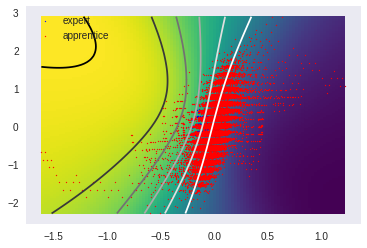

       1 |  26.0443 |  17.8381 |       26 |     4193 |   100014 |   0.6896 |   0.0100 |   0.0501 |   0.0382 |   0.0244 |   0.0094 |   0.0399 |        0 |   0.0347 |   0.0099 |   0.2358 |        0 |   1.3552 |   0.6933 |   0.5885 |   0.7980 |          |        0 |   0.6849 |   0.6849 |   0.0000 |   6.4858 |   4.9008 |   3.1169 |  34.0674
       2 |  37.7474 |  26.6135 |       37 |     5519 |   150067 |   0.6736 |   0.0667 |   0.0108 |   0.0351 |   0.0244 |   0.0095 |   0.0378 |        0 |   0.0911 |   0.0102 |   0.7047 |        0 |   1.3413 |   0.6753 |   0.5355 |   0.8152 |          |        0 |   0.7050 |   0.7050 |   0.0000 |   6.4127 |   5.0785 |   3.2962 |  50.8229
       3 |  64.5109 |  49.7508 |       64 |     6296 |   200192 |   0.6508 |   0.1267 |   0.0041 |   0.0315 |   0.0197 |   0.0092 |   0.0284 |        0 |   0.1361 |   0.0099 |   1.1351 |        0 |   1.3577 |   0.6853 |   0.5044 |   0.8663 |          |        0 |   0.7712 |   0.7712 |   0.0000 |   6.3184 |   5.4932 |   3

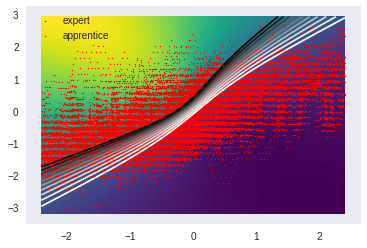

       6 | 244.8341 | 250.5332 |      244 |     7074 |   351277 |   0.5923 |  -0.1171 |   0.1559 |   0.0676 |   0.0040 |   0.0067 |   0.0072 |        0 |   0.1640 |   0.0090 |   0.4088 |        0 |   1.5685 |   0.5926 |   0.3794 |   0.8058 |          |        0 |   1.0233 |   1.0233 |   0.0000 |   6.2007 |   5.1721 |   3.5098 | 119.3897
       7 | 166.9033 | 123.2371 |      166 |     7374 |   401348 |   0.5825 |  -0.2720 |   0.6114 |   0.0712 |   0.0024 |   0.0054 |   0.0018 |        0 |   0.1872 |   0.0099 |   1.6861 |        0 |   1.3322 |   0.7854 |   0.7964 |   0.7745 |          |        0 |   0.7384 |   0.7384 |   0.0000 |   6.2602 |   5.0013 |   3.5369 | 136.2193
       8 | 173.9826 |  95.2756 |      173 |     7662 |   451455 |   0.5778 |  -0.2311 |   0.7198 |   0.0358 |   0.0022 |   0.0088 |   0.0054 |        0 |   0.1958 |   0.0101 |   1.8854 |        0 |   1.1503 |   0.7917 |   0.8868 |   0.6966 |          |        0 |   0.5476 |   0.5476 |   0.0000 |   6.2331 |   4.9621 |   3

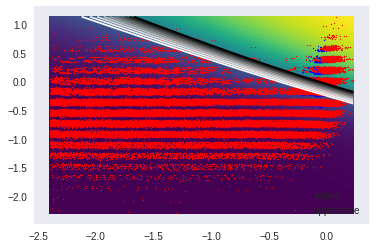

      11 | 845.6000 | 327.1160 |      845 |     8180 |   602298 |   0.5751 |   0.2596 |   0.4529 |   0.0335 |   0.0112 |   0.0089 |   0.0354 |        0 |   0.0620 |   0.0100 |   0.4433 |        0 |   0.9270 |   0.8657 |   0.9037 |   0.8277 |          |        0 |   0.3868 |   0.3868 |   0.0000 |   6.5199 |   5.3381 |   3.3206 | 204.1263
      12 | 989.0392 | 512.8345 |      989 |     8231 |   652739 |   0.5743 |   0.2795 |   0.4816 |   0.0341 |   0.0152 |   0.0091 |   0.0478 |        0 |   0.1718 |   0.0110 |   1.5134 |        0 |   0.9970 |   0.8468 |   0.7936 |   0.9000 |          |        0 |   0.5185 |   0.5185 |   0.0000 |   6.0875 |   5.3475 |   3.2388 | 220.8703
      13 | 922.4727 | 919.0723 |      922 |     8286 |   703475 |   0.5757 |   0.1423 |   0.3028 |   0.0403 |   0.0112 |   0.0095 |   0.0357 |        0 |   0.4198 |   0.0103 |   3.8934 |        0 |   1.4190 |   0.7239 |   0.5022 |   0.9456 |          |        0 |   0.9963 |   0.9963 |   0.0000 |   6.1551 |   5.2255 |   3

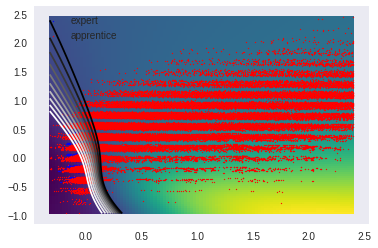

      16 | 211.3460 | 326.8139 |      211 |     8849 |   853871 |   0.5617 |  -0.0675 |   0.2813 |   0.0210 |   0.0044 |   0.0096 |   0.0097 |        0 |   0.1495 |   0.0087 |   0.5220 |        0 |   2.3427 |   0.1773 |   0.1567 |   0.1979 |          |        0 |   1.5463 |   1.5463 |   0.0000 |   6.1830 |   5.2223 |   3.4732 | 288.8687
      17 | 335.6291 | 450.3862 |      335 |     9000 |   904551 |   0.5543 |  -0.0212 |   0.2147 |   0.0148 |   0.0052 |   0.0096 |   0.0145 |        0 |   0.1502 |   0.0097 |   0.6002 |        0 |   2.3469 |   0.3530 |   0.5798 |   0.1261 |          |        0 |   1.3419 |   1.3419 |   0.0000 |   6.2171 |   5.3735 |   3.5225 | 306.1517
      18 | 659.8312 | 739.4979 |      659 |     9077 |   955358 |   0.5466 |   0.1338 |   0.3986 |   0.0200 |   0.0055 |   0.0096 |   0.0162 |        0 |   0.0692 |   0.0095 |   0.2014 |        0 |   2.2826 |   0.3766 |   0.6730 |   0.0802 |          |        0 |   1.1207 |   1.1207 |   0.0000 |   6.1855 |   5.3890 |   3

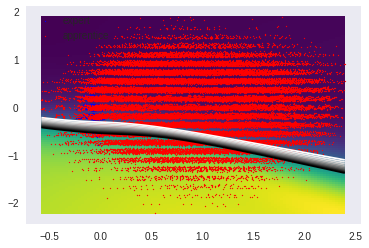

      21 | 879.3684 | 376.8596 |      879 |     9239 |  1107128 |   0.5337 |   0.5201 |   0.5528 |   0.0272 |   0.0073 |   0.0089 |   0.0197 |        0 |   0.1167 |   0.0095 |   1.2661 |        0 |   1.5670 |   0.4396 |   0.8729 |   0.0063 |          |        0 |   0.4286 |   0.4286 |   0.0000 |   6.0991 |   5.3771 |   3.4945 | 374.5038
      22 | 972.8846 | 334.4265 |      972 |     9291 |  1157718 |   0.5201 |   0.3798 |   0.5176 |   0.0221 |   0.0061 |   0.0095 |   0.0174 |        0 |   0.1023 |   0.0093 |   1.0810 |        0 |   1.3807 |   0.4843 |   0.8917 |   0.0769 |          |        0 |   0.3437 |   0.3437 |   0.0000 |   6.2792 |   5.2936 |   3.2944 | 391.5026
      23 | 899.0357 | 375.5050 |      899 |     9347 |  1208064 |   0.5176 |   0.1898 |   0.4132 |   0.0286 |   0.0055 |   0.0089 |   0.0133 |        0 |   0.0563 |   0.0089 |   0.3650 |        0 |   1.3310 |   0.5244 |   0.7752 |   0.2737 |          |        0 |   0.4177 |   0.4177 |   0.0000 |   6.0903 |   5.2881 |   3

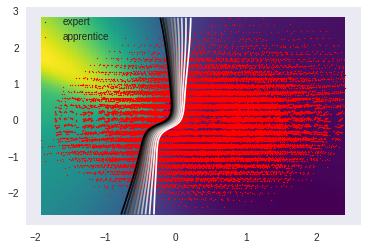

      26 | 988.5098 | 637.4982 |      988 |     9504 |  1359005 |   0.4936 |   0.4173 |   0.5725 |   0.0426 |   0.0039 |   0.0092 |   0.0105 |        0 |   0.0988 |   0.0098 |   0.7218 |        0 |   1.1653 |   0.7923 |   0.6281 |   0.9565 |          |        0 |   0.6449 |   0.6449 |   0.0000 |   6.0775 |   5.2167 |   3.3979 | 459.1022
      27 | 1000.0000 | 752.6493 |     1000 |     9554 |  1409005 |   0.4860 |   0.5142 |   0.6803 |   0.0434 |   0.0032 |   0.0094 |   0.0074 |        0 |   0.1239 |   0.0104 |   0.9560 |        0 |   1.1667 |   0.7605 |   0.5431 |   0.9778 |          |        0 |   0.7526 |   0.7526 |   0.0000 |   6.0097 |   5.1356 |   3.2752 | 475.6167
      28 | 995.9412 | 991.6413 |      995 |     9605 |  1459798 |   0.4960 |   0.5861 |   0.5914 |   0.0321 |   0.0035 |   0.0094 |   0.0100 |        0 |   0.1716 |   0.0107 |   1.5937 |        0 |   1.3325 |   0.6888 |   0.3871 |   0.9905 |          |        0 |   0.9957 |   0.9957 |   0.0000 |   6.0996 |   5.4028 |   

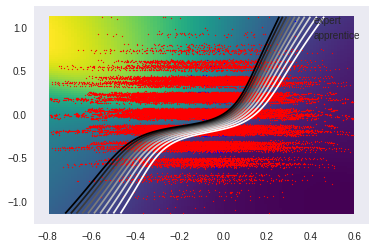

      31 | 1000.0000 | 1618.5118 |     1000 |     9755 |  1609798 |   0.4725 |   0.6110 |   0.9060 |   0.0287 |   0.0048 |   0.0096 |   0.0129 |        0 |   0.2105 |   0.0103 |   1.9971 |        0 |   1.9660 |   0.4740 |   0.0614 |   0.8866 |          |        0 |   1.6185 |   1.6185 |   0.0000 |   6.0114 |   5.0329 |   3.0197 | 541.1160
      32 | 1000.0000 | 1626.1919 |     1000 |     9805 |  1659798 |   0.4621 |   0.6814 |   0.9695 |   0.0325 |   0.0024 |   0.0097 |   0.0073 |        0 |   0.1315 |   0.0103 |   1.2275 |        0 |   2.0580 |   0.4295 |   0.0789 |   0.7802 |          |        0 |   1.6262 |   1.6262 |   0.0000 |   5.9710 |   5.0892 |   3.1732 | 557.4073
      33 | 1000.0000 | 1434.6480 |     1000 |     9855 |  1709798 |   0.4550 |   0.7637 |   0.9648 |   0.0308 |   0.0022 |   0.0096 |   0.0075 |        0 |   0.0323 |   0.0076 |   0.0901 |        0 |   1.9589 |   0.4405 |   0.1904 |   0.6906 |          |        0 |   1.4346 |   1.4346 |   0.0000 |   6.0030 |   5.0718

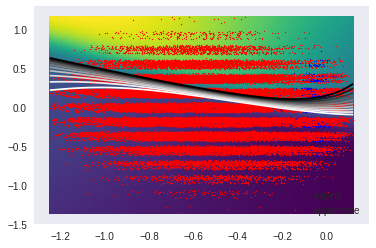

      36 | 989.8431 | 964.2391 |      989 |    10006 |  1860280 |   0.4458 |   0.7349 |   0.8672 |   0.0861 |   0.0031 |   0.0080 |   0.0099 |        0 |   0.1090 |   0.0099 |   1.1041 |        0 |   1.5506 |   0.7225 |   0.5977 |   0.8473 |          |        0 |   0.9741 |   0.9741 |   0.0000 |   6.1230 |   5.3046 |   3.5047 | 623.2925
      37 | 1000.0000 | 807.5720 |     1000 |    10056 |  1910280 |   0.4576 |   0.7525 |   0.8799 |   0.0895 |   0.0024 |   0.0070 |   0.0036 |        0 |   0.1391 |   0.0098 |   1.4420 |        0 |   1.3305 |   0.7839 |   0.6456 |   0.9222 |          |        0 |   0.8076 |   0.8076 |   0.0000 |   6.0304 |   5.2878 |   3.4202 | 640.2029
      38 | 1000.0000 | 770.3249 |     1000 |    10106 |  1960280 |   0.4684 |   0.7754 |   0.8959 |   0.0583 |   0.0028 |   0.0084 |   0.0092 |        0 |   0.1211 |   0.0099 |   1.2608 |        0 |   1.2245 |   0.7932 |   0.6382 |   0.9482 |          |        0 |   0.7703 |   0.7703 |   0.0000 |   6.0465 |   5.2414 |  

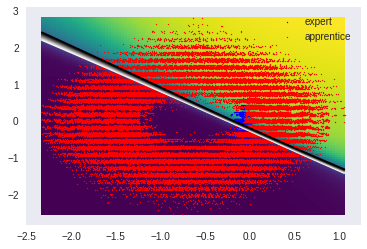

      41 | 812.3548 | 632.0726 |      812 |    10277 |  2111618 |   0.4588 |   0.6719 |   0.7548 |   0.0504 |   0.0064 |   0.0080 |   0.0382 |        0 |   0.0945 |   0.0100 |   0.9891 |        0 |   1.0312 |   0.8080 |   0.6308 |   0.9851 |          |        0 |   0.7781 |   0.7781 |   0.0000 |   6.1710 |   5.3601 |   3.7652 | 710.2150
      42 | 783.5312 | 590.9921 |      783 |    10341 |  2161764 |   0.4494 |   0.7198 |   0.7583 |   0.0400 |   0.0043 |   0.0082 |   0.0139 |        0 |   0.0980 |   0.0099 |   1.0482 |        0 |   0.9644 |   0.8118 |   0.6341 |   0.9894 |          |        0 |   0.7543 |   0.7543 |   0.0000 |   6.1114 |   5.3132 |   3.7526 | 727.5912
      43 | 703.3889 | 509.2813 |      703 |    10413 |  2212408 |   0.4344 |   0.7157 |   0.7513 |   0.0352 |   0.0059 |   0.0082 |   0.0207 |        0 |   0.1126 |   0.0099 |   1.1826 |        0 |   0.9022 |   0.8149 |   0.6378 |   0.9920 |          |        0 |   0.7240 |   0.7240 |   0.0000 |   6.1683 |   5.3578 |   3

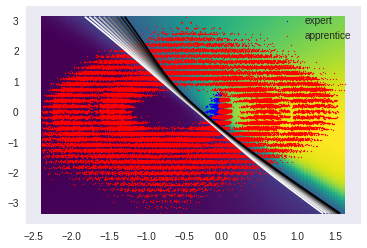

      46 | 589.4353 | 345.5142 |      589 |    10659 |  2363489 |   0.4093 |   0.5578 |   0.7418 |   0.0373 |   0.0057 |   0.0073 |   0.0237 |        0 |   0.1304 |   0.0102 |   1.2861 |        0 |   0.7440 |   0.8782 |   0.7857 |   0.9707 |          |        0 |   0.5862 |   0.5862 |   0.0000 |   6.1964 |   5.3294 |   3.8716 | 797.8377
      47 | 607.8916 | 326.1576 |      607 |    10742 |  2413944 |   0.3965 |   0.4730 |   0.7656 |   0.0390 |   0.0064 |   0.0088 |   0.0218 |        0 |   0.1189 |   0.0101 |   1.1471 |        0 |   0.7053 |   0.8978 |   0.8393 |   0.9562 |          |        0 |   0.5365 |   0.5365 |   0.0000 |   6.1817 |   5.3225 |   3.7902 | 815.3376
      48 | 616.2561 | 329.3788 |      616 |    10824 |  2464477 |   0.3914 |   0.2879 |   0.7910 |   0.0398 |   0.0057 |   0.0089 |   0.0192 |        0 |   0.0978 |   0.0101 |   0.8517 |        0 |   0.7148 |   0.8610 |   0.7725 |   0.9495 |          |        0 |   0.5345 |   0.5345 |   0.0000 |   6.2143 |   5.2982 |   3

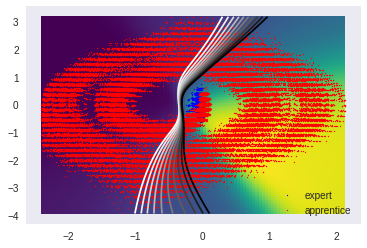

      51 | 605.4458 | 398.1886 |      605 |    11075 |  2615411 |   0.3679 |   0.2368 |   0.4620 |   0.0356 |   0.0072 |   0.0094 |   0.0243 |        0 |   0.0370 |   0.0099 |   0.2624 |        0 |   0.8244 |   0.8179 |   0.6596 |   0.9762 |          |        0 |   0.6577 |   0.6577 |   0.0000 |   6.2157 |   5.2834 |   3.7579 | 885.2897
      52 | 663.7105 | 486.9814 |      663 |    11151 |  2665853 |   0.3592 |   0.4896 |   0.5902 |   0.0434 |   0.0078 |   0.0093 |   0.0286 |        0 |   0.0350 |   0.0100 |   0.3275 |        0 |   0.8883 |   0.8033 |   0.6169 |   0.9897 |          |        0 |   0.7337 |   0.7337 |   0.0000 |   6.1931 |   5.3059 |   3.7495 | 902.7572
      53 | 701.1250 | 553.0323 |      701 |    11223 |  2716334 |   0.3456 |   0.7655 |   0.7938 |   0.0563 |   0.0121 |   0.0089 |   0.0445 |        0 |   0.0246 |   0.0099 |   0.3052 |        0 |   0.9332 |   0.7838 |   0.5786 |   0.9890 |          |        0 |   0.7888 |   0.7888 |   0.0000 |   6.1775 |   5.3243 |   3

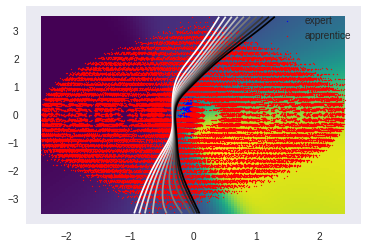

      56 | 941.9074 | 958.3958 |      941 |    11405 |  2867962 |   0.3290 |   0.5850 |   0.8343 |   0.0879 |   0.0080 |   0.0087 |   0.0301 |        0 |   0.0960 |   0.0097 |   0.6780 |        0 |   1.2135 |   0.7153 |   0.5150 |   0.9157 |          |        0 |   1.0175 |   1.0175 |   0.0000 |   6.2447 |   5.3368 |   3.7077 | 972.5423
      57 | 965.8846 | 1093.3390 |      965 |    11457 |  2918188 |   0.3196 |   0.5548 |   0.8429 |   0.0857 |   0.0061 |   0.0091 |   0.0238 |        0 |   0.1257 |   0.0097 |   0.8214 |        0 |   1.3682 |   0.6863 |   0.4968 |   0.8758 |          |        0 |   1.1320 |   1.1320 |   0.0000 |   6.1257 |   5.3985 |   3.8179 | 990.1693
      58 | 960.3396 | 1072.4353 |      960 |    11510 |  2969086 |   0.3157 |   0.5907 |   0.8308 |   0.0771 |   0.0061 |   0.0091 |   0.0233 |        0 |   0.0913 |   0.0093 |   0.4683 |        0 |   1.3997 |   0.6790 |   0.5121 |   0.8460 |          |        0 |   1.1167 |   1.1167 |   0.0000 |   6.2220 |   5.2875 |  

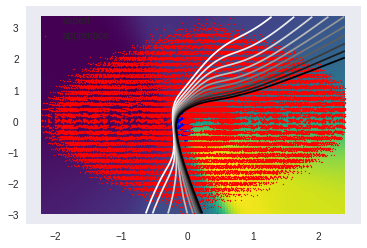

      61 | 987.6275 | 803.6029 |      987 |    11664 |  3119921 |   0.3177 |   0.8681 |   0.9027 |   0.1001 |   0.0054 |   0.0094 |   0.0186 |        0 |   0.0315 |   0.0083 |   0.3429 |        0 |   1.2470 |   0.7194 |   0.6380 |   0.8009 |          |        0 |   0.8137 |   0.8137 |   0.0000 |   6.1568 |   5.3080 |   3.7372 | 1059.4992
      62 | 991.8431 | 736.5661 |      991 |    11715 |  3170505 |   0.3143 |   0.8812 |   0.9192 |   0.0482 |   0.0032 |   0.0087 |   0.0096 |        0 |   0.0339 |   0.0086 |   0.3335 |        0 |   1.2056 |   0.7711 |   0.6941 |   0.8482 |          |        0 |   0.7426 |   0.7426 |   0.0000 |   6.1279 |   5.3448 |   3.7217 | 1076.9030
      63 | 1000.0000 | 748.7690 |     1000 |    11765 |  3220505 |   0.3133 |   0.8578 |   0.9147 |   0.0847 |   0.0046 |   0.0090 |   0.0150 |        0 |   0.0210 |   0.0083 |   0.0954 |        0 |   1.2289 |   0.8137 |   0.7130 |   0.9144 |          |        0 |   0.7488 |   0.7488 |   0.0000 |   6.0680 |   5.3361 | 

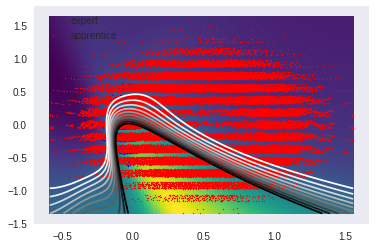

      66 | 1000.0000 | 702.3996 |     1000 |    11915 |  3370505 |   0.2998 |   0.8843 |   0.9404 |   0.0900 |   0.0029 |   0.0086 |   0.0084 |        0 |   0.0616 |   0.0103 |   0.6742 |        0 |   1.2109 |   0.8251 |   0.7789 |   0.8714 |          |        0 |   0.7024 |   0.7024 |   0.0000 |   6.0548 |   5.1132 |   3.3519 | 1145.0886
      67 | 1000.0000 | 519.3315 |     1000 |    11965 |  3420505 |   0.2933 |   0.8612 |   0.9369 |   0.0524 |   0.0038 |   0.0087 |   0.0168 |        0 |   0.1221 |   0.0099 |   1.2746 |        0 |   1.0456 |   0.9023 |   0.9576 |   0.8470 |          |        0 |   0.5193 |   0.5193 |   0.0000 |   6.0149 |   5.2136 |   3.1515 | 1161.6269
      68 | 1000.0000 | 391.8694 |     1000 |    12015 |  3470505 |   0.2947 |   0.5585 |   0.9044 |   0.0539 |   0.0060 |   0.0079 |   0.0298 |        0 |   0.1507 |   0.0100 |   1.5306 |        0 |   0.9262 |   0.9136 |   0.9838 |   0.8433 |          |        0 |   0.3919 |   0.3919 |   0.0000 |   6.0333 |   5.2094 

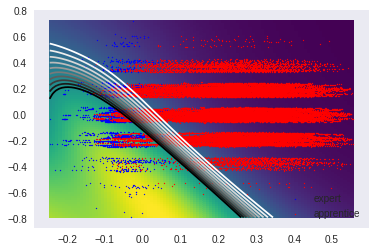

      71 | 1000.0000 | 415.6035 |     1000 |    12165 |  3620505 |   0.3031 |   0.5213 |   0.5681 |   0.0192 |   0.0133 |   0.0095 |   0.0634 |        0 |   0.0643 |   0.0105 |   0.6247 |        0 |   0.8701 |   0.8976 |   0.9027 |   0.8924 |          |        0 |   0.4156 |   0.4156 |   0.0000 |   6.0374 |   5.1977 |   2.9420 | 1227.0845
      72 | 1000.0000 | 717.8815 |     1000 |    12215 |  3670505 |   0.3010 |   0.4729 |   0.5067 |   0.0159 |   0.0143 |   0.0095 |   0.0657 |        0 |   0.0873 |   0.0080 |   0.8472 |        0 |   1.1432 |   0.7456 |   0.6126 |   0.8786 |          |        0 |   0.7179 |   0.7179 |   0.0000 |   6.0283 |   5.1856 |   2.8835 | 1243.3201
      73 | 1000.0000 | 1232.0527 |     1000 |    12265 |  3720505 |   0.2977 |   0.4518 |   0.6564 |   0.0117 |   0.0158 |   0.0096 |   0.0750 |        0 |   0.3102 |   0.0099 |   3.0334 |        0 |   1.6776 |   0.4987 |   0.2288 |   0.7686 |          |        0 |   1.2321 |   1.2321 |   0.0000 |   6.0118 |   5.0609

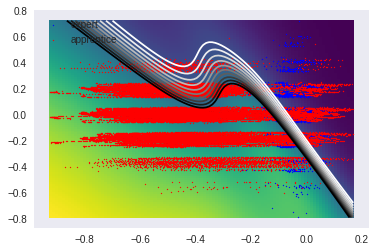

      76 | 1000.0000 | 1680.7383 |     1000 |    12415 |  3870505 |   0.2942 |   0.6154 |   0.9131 |   0.0149 |   0.0147 |   0.0099 |   0.0712 |        0 |   0.1655 |   0.0101 |   1.6439 |        0 |   2.3481 |   0.3991 |   0.0409 |   0.7574 |          |        0 |   1.6807 |   1.6807 |   0.0000 |   6.3464 |   5.0868 |   2.9945 | 1308.5496
      77 | 1000.0000 | 1472.0960 |     1000 |    12465 |  3920505 |   0.2926 |   0.7182 |   0.9321 |   0.0158 |   0.0131 |   0.0098 |   0.0643 |        0 |   0.0510 |   0.0090 |   0.6168 |        0 |   2.0399 |   0.6424 |   0.3925 |   0.8922 |          |        0 |   1.4721 |   1.4721 |   0.0000 |   6.0315 |   5.0987 |   2.9917 | 1324.8419
      78 | 1000.0000 | 989.5861 |     1000 |    12515 |  3970505 |   0.2896 |   0.8488 |   0.9487 |   0.0193 |   0.0116 |   0.0099 |   0.0551 |        0 |   0.2251 |   0.0098 |   2.4026 |        0 |   1.4141 |   0.9334 |   0.9106 |   0.9562 |          |        0 |   0.9896 |   0.9896 |   0.0000 |   6.0551 |   5.235

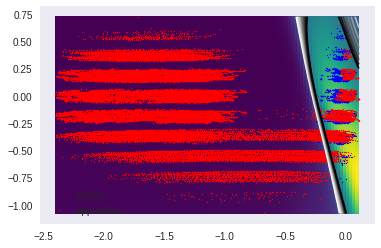

      81 | 335.3267 | 179.3790 |      335 |    12768 |  4121744 |   0.3004 |  -0.8465 |   0.9422 |   0.0938 |   0.0020 |   0.0070 |   0.0045 |        0 |   0.3971 |   0.0098 |   3.9095 |        0 |   0.6758 |   0.9089 |   0.8189 |   0.9988 |          |        0 |   0.5349 |   0.5349 |   0.0000 |   6.1734 |   5.1615 |   3.8045 | 1392.6702
      82 | 251.4372 | 175.9881 |      251 |    12967 |  4171780 |   0.2957 |  -0.4909 |   0.9458 |   0.0562 |   0.0020 |   0.0087 |   0.0058 |        0 |   0.4028 |   0.0099 |   3.9530 |        0 |   0.8018 |   0.8880 |   0.7763 |   0.9997 |          |        0 |   0.6999 |   0.6999 |   0.0000 |   6.6364 |   5.2895 |   3.5245 | 1410.3236
      83 | 219.4605 | 168.8081 |      219 |    13195 |  4221817 |   0.3012 |  -0.3463 |   0.9538 |   0.0477 |   0.0017 |   0.0087 |   0.0051 |        0 |   0.3937 |   0.0098 |   3.9009 |        0 |   0.8484 |   0.8849 |   0.7701 |   0.9998 |          |        0 |   0.7692 |   0.7692 |   0.0000 |   6.1766 |   5.1136 |  

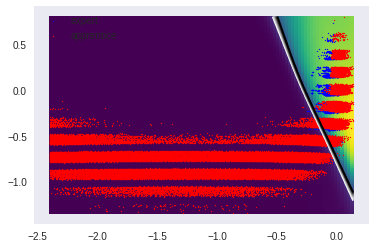

      86 | 186.2230 | 140.1867 |      186 |    13972 |  4372272 |   0.3369 |  -0.1831 |   0.9339 |   0.0433 |   0.0008 |   0.0071 |   0.0018 |        0 |   0.3445 |   0.0099 |   3.4675 |        0 |   0.8084 |   0.8920 |   0.7883 |   0.9958 |          |        0 |   0.7528 |   0.7528 |   0.0000 |   6.2405 |   5.0824 |   3.7933 | 1479.5007
      87 | 175.0979 | 115.7731 |      175 |    14258 |  4422350 |   0.3565 |  -0.1449 |   0.9319 |   0.0537 |   0.0017 |   0.0085 |   0.0070 |        0 |   0.3311 |   0.0100 |   3.3638 |        0 |   0.7183 |   0.9029 |   0.8128 |   0.9931 |          |        0 |   0.6612 |   0.6612 |   0.0000 |   6.2281 |   5.0839 |   3.7103 | 1496.7400
      88 | 172.4690 |  95.9713 |      172 |    14548 |  4472366 |   0.3583 |  -0.0999 |   0.9224 |   0.0534 |   0.0015 |   0.0070 |   0.0071 |        0 |   0.3136 |   0.0100 |   3.2159 |        0 |   0.6176 |   0.9147 |   0.8395 |   0.9900 |          |        0 |   0.5565 |   0.5565 |   0.0000 |   6.2671 |   5.1103 |  

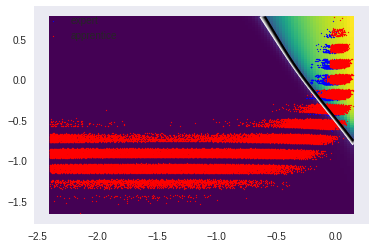

      91 | 169.7390 |  61.5584 |      169 |    15437 |  4622677 |   0.3292 |  -0.0014 |   0.7891 |   0.0685 |   0.0028 |   0.0082 |   0.0076 |        0 |   0.2479 |   0.0099 |   2.5788 |        0 |   0.4475 |   0.9359 |   0.8881 |   0.9838 |          |        0 |   0.3627 |   0.3627 |   0.0000 |   6.2364 |   4.7495 |   3.4405 | 1564.2240
      92 | 177.0707 |  59.3262 |      177 |    15720 |  4672788 |   0.3156 |   0.0730 |   0.6936 |   0.0441 |   0.0026 |   0.0068 |   0.0058 |        0 |   0.2237 |   0.0100 |   2.3292 |        0 |   0.4343 |   0.9355 |   0.8931 |   0.9780 |          |        0 |   0.3350 |   0.3350 |   0.0000 |   6.2159 |   5.0747 |   3.3864 | 1581.1256
      93 | 188.1128 |  58.7899 |      188 |    15986 |  4722826 |   0.3304 |   0.1412 |   0.5737 |   0.0356 |   0.0040 |   0.0078 |   0.0104 |        0 |   0.1971 |   0.0099 |   2.0676 |        0 |   0.4286 |   0.9285 |   0.8951 |   0.9618 |          |        0 |   0.3125 |   0.3125 |   0.0000 |   6.2134 |   5.3011 |  

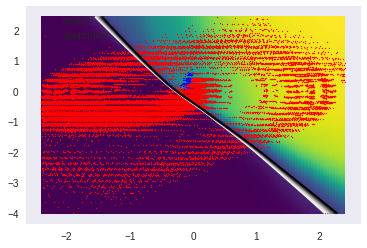

      96 | 506.8200 | 862.2862 |      506 |    16446 |  4873869 |   0.3565 |   0.1544 |   0.0942 |   0.0604 |   0.0068 |   0.0092 |   0.0259 |        0 |   0.4445 |   0.0098 |   3.4732 |        0 |   1.9555 |   0.6870 |   0.5080 |   0.8661 |          |        0 |   1.7014 |   1.7014 |   0.0000 |   6.2147 |   5.2226 |   3.8411 | 1650.8042
      97 | 380.9773 | 1098.5811 |      380 |    16578 |  4924158 |   0.3858 |   0.2412 |   0.5511 |   0.0384 |   0.0080 |   0.0096 |   0.0264 |        0 |   0.5610 |   0.0100 |   4.6525 |        0 |   3.2147 |   0.5494 |   0.2583 |   0.8405 |          |        0 |   2.8836 |   2.8836 |   0.0000 |   6.2109 |   5.2161 |   3.7414 | 1668.2069
      98 | 235.2347 | 812.0083 |      235 |    16791 |  4974263 |   0.3999 |   0.2076 |   0.6189 |   0.0385 |   0.0089 |   0.0094 |   0.0213 |        0 |   0.3818 |   0.0097 |   3.2149 |        0 |   3.8593 |   0.4663 |   0.1120 |   0.8206 |          |        0 |   3.4519 |   3.4519 |   0.0000 |   6.2306 |   5.1781 | 

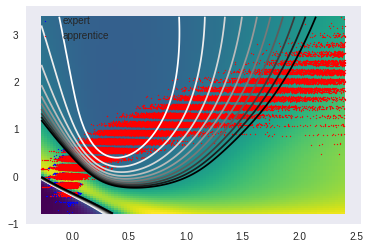

     101 | 147.8083 | 247.0449 |      147 |    17740 |  5124559 |   0.4081 |   0.3178 |   0.8732 |   0.0637 |   0.0031 |   0.0087 |   0.0069 |        0 |   0.2029 |   0.0099 |   2.0458 |        0 |   2.1718 |   0.6386 |   0.4893 |   0.7879 |          |        0 |   1.6714 |   1.6714 |   0.0000 |   6.2423 |   5.3034 |   3.8830 | 1738.4530
     102 | 138.3950 | 141.3415 |      138 |    18102 |  5174658 |   0.3991 |   0.3885 |   0.8631 |   0.0320 |   0.0015 |   0.0076 |   0.0021 |        0 |   0.2328 |   0.0099 |   2.4111 |        0 |   1.5343 |   0.7311 |   0.6911 |   0.7711 |          |        0 |   1.0213 |   1.0213 |   0.0000 |   6.2397 |   5.2106 |   3.9025 | 1756.0437
     103 | 131.1361 |  83.8436 |      131 |    18484 |  5224752 |   0.3939 |   0.3129 |   0.8337 |   0.0378 |   0.0018 |   0.0073 |   0.0015 |        0 |   0.2393 |   0.0099 |   2.4824 |        0 |   1.1726 |   0.7747 |   0.7912 |   0.7583 |          |        0 |   0.6394 |   0.6394 |   0.0000 |   6.3048 |   5.2085 |  

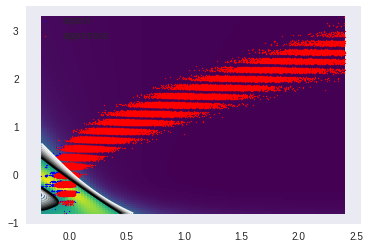

     106 | 120.0911 |  23.3832 |      120 |    19697 |  5374861 |   0.4225 |  -4.0045 |   0.8072 |   0.0253 |   0.0024 |   0.0090 |   0.0082 |        0 |   0.1990 |   0.0099 |   2.0813 |        0 |   0.7686 |   0.8411 |   0.9612 |   0.7211 |          |        0 |   0.1947 |   0.1947 |   0.0000 |   6.2409 |   5.2355 |   3.8547 | 1826.1683
     107 | 117.2974 |  19.9171 |      117 |    20124 |  5424947 |   0.4239 |  -3.7937 |   0.7749 |   0.0690 |   0.0022 |   0.0071 |   0.0071 |        0 |   0.1806 |   0.0099 |   1.9039 |        0 |   0.7111 |   0.8600 |   0.9550 |   0.7649 |          |        0 |   0.1698 |   0.1698 |   0.0000 |   6.2656 |   5.1956 |   3.7253 | 1843.5820
     108 | 119.9424 |  17.8297 |      119 |    20541 |  5474963 |   0.4208 |  -4.7506 |   0.7368 |   0.0503 |   0.0020 |   0.0067 |   0.0040 |        0 |   0.1577 |   0.0098 |   1.6772 |        0 |   0.6242 |   0.8970 |   0.9513 |   0.8427 |          |        0 |   0.1487 |   0.1487 |   0.0000 |   6.2361 |   5.2388 |  

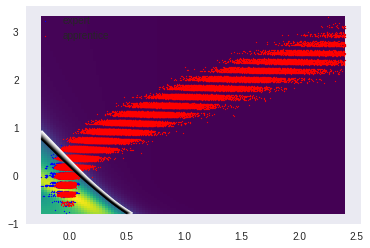

     111 | 130.7467 |  30.6985 |      130 |    21738 |  5625164 |   0.4261 |   0.2101 |   0.4594 |   0.0640 |   0.0070 |   0.0083 |   0.0140 |        0 |   0.0905 |   0.0099 |   0.9955 |        0 |   0.4370 |   0.9349 |   0.8802 |   0.9896 |          |        0 |   0.2348 |   0.2348 |   0.0000 |   6.4317 |   5.2745 |   3.8467 | 1913.9694
     112 | 141.3729 |  53.2137 |      141 |    22092 |  5675210 |   0.4245 |   0.2426 |   0.1169 |   0.0851 |   0.0094 |   0.0089 |   0.0216 |        0 |   0.0641 |   0.0084 |   0.6419 |        0 |   0.5213 |   0.9053 |   0.8183 |   0.9923 |          |        0 |   0.3764 |   0.3764 |   0.0000 |   6.2525 |   5.1320 |   3.7101 | 1931.2743
     113 | 143.8793 | 157.8601 |      143 |    22440 |  5725280 |   0.4268 |   0.3086 |   0.1730 |   0.1386 |   0.0099 |   0.0078 |   0.0313 |        0 |   0.1058 |   0.0079 |   0.3642 |        0 |   1.2061 |   0.7943 |   0.5947 |   0.9939 |          |        0 |   1.0972 |   1.0972 |   0.0000 |   6.2270 |   5.1444 |  

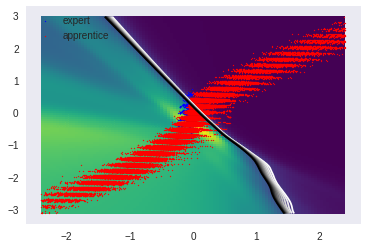

     116 | 125.6332 | 382.5632 |      125 |    23607 |  5875409 |   0.4086 |   0.2918 |   0.6026 |   0.0602 |   0.0102 |   0.0088 |   0.0297 |        0 |   0.1715 |   0.0095 |   1.1889 |        0 |   3.1440 |   0.5283 |   0.0832 |   0.9735 |          |        0 |   3.0451 |   3.0451 |   0.0000 |   6.2179 |   5.3616 |   3.8435 | 2001.0482
     117 | 121.2809 | 364.5568 |      121 |    24020 |  5925498 |   0.3967 |   0.4171 |   0.8477 |   0.0664 |   0.0064 |   0.0079 |   0.0208 |        0 |   0.1072 |   0.0092 |   0.4471 |        0 |   3.1279 |   0.4937 |   0.0202 |   0.9671 |          |        0 |   3.0059 |   3.0059 |   0.0000 |   6.4920 |   5.4005 |   3.7964 | 2018.9603
     118 | 119.9880 | 307.6288 |      119 |    24437 |  5975533 |   0.3817 |   0.6307 |   0.9083 |   0.0519 |   0.0033 |   0.0072 |   0.0153 |        0 |   0.0649 |   0.0094 |   0.4930 |        0 |   2.7027 |   0.5019 |   0.0333 |   0.9705 |          |        0 |   2.5638 |   2.5638 |   0.0000 |   6.2346 |   5.4040 |  

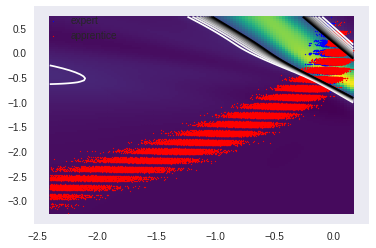

     121 | 128.5347 | 152.5738 |      128 |    25641 |  6125635 |   0.3339 |   0.6066 |   0.8682 |   0.0947 |   0.0038 |   0.0075 |   0.0126 |        0 |   0.1660 |   0.0099 |   1.6861 |        0 |   1.3076 |   0.8629 |   0.7264 |   0.9993 |          |        0 |   1.1870 |   1.1870 |   0.0000 |   6.2381 |   5.1762 |   3.6434 | 2088.7308


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

log = nn.TrainingLog(log, [])
for i in xrange(max_iter):
    iter_info = opt.step()
    log.write(iter_info, print_header=i % (20*print_freq) == 0, display=i % print_freq == 0)
    if save_freq != 0 and i % save_freq == 0 and log is not None:
        log.write_snapshot(policy, i)

    if plot_freq != 0 and i % plot_freq == 0:
        exdata_N_Doa = np.concatenate([exobs_Bstacked_Do, exa_Bstacked_Da], axis=1)
        pdata_M_Doa = np.concatenate([opt.last_sampbatch.obs.stacked, opt.last_sampbatch.a.stacked], axis=1)

        # Plot reward
        _, ax = plt.subplots()
        idx1, idx2 = 0,1
        range1 = (min(exdata_N_Doa[:,idx1].min(), pdata_M_Doa[:,idx1].min()), max(exdata_N_Doa[:,idx1].max(), pdata_M_Doa[:,idx1].max()))
        range2 = (min(exdata_N_Doa[:,idx2].min(), pdata_M_Doa[:,idx2].min()), max(exdata_N_Doa[:,idx2].max(), pdata_M_Doa[:,idx2].max()))
        reward.plot(ax, idx1, idx2, range1, range2, n=100)

        # Plot expert data
        ax.scatter(exdata_N_Doa[:,idx1], exdata_N_Doa[:,idx2], color='blue', s=1, label='expert')

        # Plot policy samples
        ax.scatter(pdata_M_Doa[:,idx1], pdata_M_Doa[:,idx2], color='red', s=1, label='apprentice')

        ax.legend()
        plt.show()

## Evaluation : 학습된 Policy 실행시켜보기

In [0]:
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.pyplot import imshow
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import display, HTML

def plot_movie_mp4(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(HTML(anim.to_html5_video()))

def plot_movie_js(image_array):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    display(IPython_display.display_animation(anim))

In [0]:
returns = []
lengths = []

sim = mdp.new_sim()
n = 1
for i_traj in xrange(n):
    print i_traj, n
    sim.reset()
    totalr = 0.
    l = 0
    images = []
    while not sim.done:
        a = policy.sample_actions(sim.obs[None,:], bool(args.deterministic))[0][0,:]
        r = sim.step(a)
        img = sim.draw_image()
        images.append(img)
        totalr += r
        l += 1
    returns.append(totalr)
    lengths.append(l)